<a href="https://colab.research.google.com/github/BrunoGolei/CasePetLove/blob/main/PETLOVE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTS Necessários para realização das análises.


In [ ]:
import pandas as pd 
import io
import requests
import matplotlib.pyplot as plt 
from datetime import datetime, date
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

Importando Dataset de uma url

In [ ]:
url="https://raw.githubusercontent.com/petlove/vagas/master/data/bi-analysis/data-test-analytics.csv"
dataset=pd.read_csv(io.StringIO(requests.get(url).content.decode('utf-8')))
dataset.head()

,id,created_at,updated_at,deleted_at,name_hash,email_hash,address_hash,birth_date,status,version,city,state,neighborhood,last_date_purchase,average_ticket,items_quantity,all_revenue,all_orders,recency,marketing_source
0,8bf7960e-3b93-468b-856e-6c6c5b56f52b,2017-08-15 07:05:04.000000,2021-01-14 11:23:50.659119,NaN,312d206168a318614897e8ccac43bff9,83eb3aed9a44377df80ce876dce92c9a,8b4bfaa0cbc41a16f46da15ddcd6a907,1974-07-10 00:00:00.000000,active,2.31.7,Peixoto da Praia,AM,Aparecida 7ª Seção,2021-01-14 11:23:50.659119,151.142942,10,906.857651,6,35,crm
1,a39535b5-4647-4680-b4f6-3aed57c1f1ff,2019-12-31 21:53:34.000000,2021-01-08 11:23:50.660183,NaN,de448fcb47d0d6a873b2eef52b5ee595,72678bb35e2ac84ed373e81dd9dca28c,22f1cfa1847f38da3f3cb114dd2b9247,1940-07-06 00:00:00.000000,paused,3.30.12,Fernandes,RR,Santa Isabel,2021-01-08 11:23:50.660183,236.991790,4,236.991790,1,41,organic_search
2,dc067cd2-c021-42bd-8c0e-beb267280e66,2019-03-07 23:46:51.000000,2021-01-07 11:23:50.660990,NaN,cb09e447ddc38283373d56bb46498e6a,668f4ee9add29c7bd02c485f1b7509e3,6cb47446a086ee6483b3eb954f11467a,1963-03-18 00:00:00.000000,active,3.28.9,Lopes,RR,Estrela,2021-01-07 11:23:50.660990,211.955597,13,2331.511572,11,42,organic_search
3,b5e4caeb-3a9b-49ed-aa33-5acd06b162c1,2018-07-21 10:17:57.000000,2021-01-10 11:23:50.661827,NaN,52593437a405b11b3557170680ef80c8,d3fb45188d95c8d7cc49da5b4f727c86,0a6f0c54db1e6f19347f96b50f8092a4,1980-11-21 00:00:00.000000,active,3.34.3,Campos do Campo,PE,Confisco,2021-01-10 11:23:50.661827,204.113227,8,1224.679359,6,39,organic_search
4,d4ff61fc-f008-4e19-b8ae-bd70cfa3ae27,2018-06-08 12:09:50.000000,2021-01-18 11:23:50.662621,NaN,dbda4b778a966c21904238ed2d2005db,a0f76bc49b4c43327b536da6e1a1465e,143b9f169b4fa1692f6d79b5682169b5,1959-07-07 00:00:00.000000,active,3.19.8,das Neves,RJ,Vila Suzana Segunda Seção,2021-01-18 11:23:50.662621,252.940997,9,2023.527980,8,31,crm


Limpando o dataset e adiconando novas features

In [ ]:
dataset['deleted_at'] = pd.to_datetime(dataset['deleted_at'])
dataset['created_at'] = pd.to_datetime(dataset['created_at'])
dataset['updated_at'] = pd.to_datetime(dataset['updated_at'])
dataset['birth_date'] = pd.to_datetime(dataset['birth_date'])
dataset['last_date_purchase'] = pd.to_datetime(dataset['last_date_purchase'])

#Convertendo data de aniversario para a medida de idade
dataset['age'] = dataset['birth_date'].apply(
               lambda x: date.today().year  - x.year - 
               ((date.today().month, date.today().day) < (x.month, x.day)))

#Por quanto dias corridos o cliente teve/tem assinatura ativa
dataset['LastDayAsCustomer'] = dataset['deleted_at']
dataset['LastDayAsCustomer'] = dataset.loc[(dataset.deleted_at.isnull()),'LastDayAsCustomer'] = pd.to_datetime(datetime.today())
dataset['lifetime'] = (dataset['LastDayAsCustomer'] - dataset['created_at']).dt.days

#Total de dias que o cliente ficou sem comprar antes de cancelar
dataset['days_without_buying_before_canceling'] = (dataset['deleted_at'] - dataset['last_date_purchase']).dt.days
dataset['days_without_buying_before_canceling'] = dataset['days_without_buying_before_canceling'].fillna(0)


dataset = dataset.drop(labels = ["id","name_hash","email_hash","address_hash","birth_date","LastDayAsCustomer"],axis = 1)

dataset.head()

,created_at,updated_at,deleted_at,status,version,city,state,neighborhood,last_date_purchase,average_ticket,items_quantity,all_revenue,all_orders,recency,marketing_source,age,lifetime,days_without_buying_before_canceling
0,2017-08-15 07:05:04,2021-01-14 11:23:50.659119,NaT,active,2.31.7,Peixoto da Praia,AM,Aparecida 7ª Seção,2021-01-14 11:23:50.659119,151.142942,10,906.857651,6,35,crm,46,1293,0.0
1,2019-12-31 21:53:34,2021-01-08 11:23:50.660183,NaT,paused,3.30.12,Fernandes,RR,Santa Isabel,2021-01-08 11:23:50.660183,236.991790,4,236.991790,1,41,organic_search,80,424,0.0
2,2019-03-07 23:46:51,2021-01-07 11:23:50.660990,NaT,active,3.28.9,Lopes,RR,Estrela,2021-01-07 11:23:50.660990,211.955597,13,2331.511572,11,42,organic_search,57,723,0.0
3,2018-07-21 10:17:57,2021-01-10 11:23:50.661827,NaT,active,3.34.3,Campos do Campo,PE,Confisco,2021-01-10 11:23:50.661827,204.113227,8,1224.679359,6,39,organic_search,40,953,0.0
4,2018-06-08 12:09:50,2021-01-18 11:23:50.662621,NaT,active,3.19.8,das Neves,RJ,Vila Suzana Segunda Seção,2021-01-18 11:23:50.662621,252.940997,9,2023.527980,8,31,crm,61,996,0.0


Criando uma copia do data set e transformando as variaveis categoricas

In [ ]:
datasetencode = dataset.copy()
datasetencode['state_code'] = LabelEncoder().fit_transform(dataset['state'])
datasetencode['city_code'] = LabelEncoder().fit_transform(dataset['city'])
datasetencode['status_code'] = LabelEncoder().fit_transform(dataset['status'])
datasetencode['marketing_source_code'] = LabelEncoder().fit_transform(dataset['marketing_source'])

Análise Exploratória

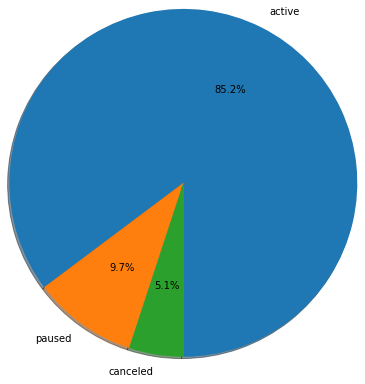

In [ ]:
#Medindo tamanho de base por status
x = dataset['status'].value_counts(sort = True)
y = dataset['status'].value_counts(sort = True).index
plt.pie(x, labels=y,autopct='%1.1f%%', shadow=True, startangle=270,radius=2)
plt.show()

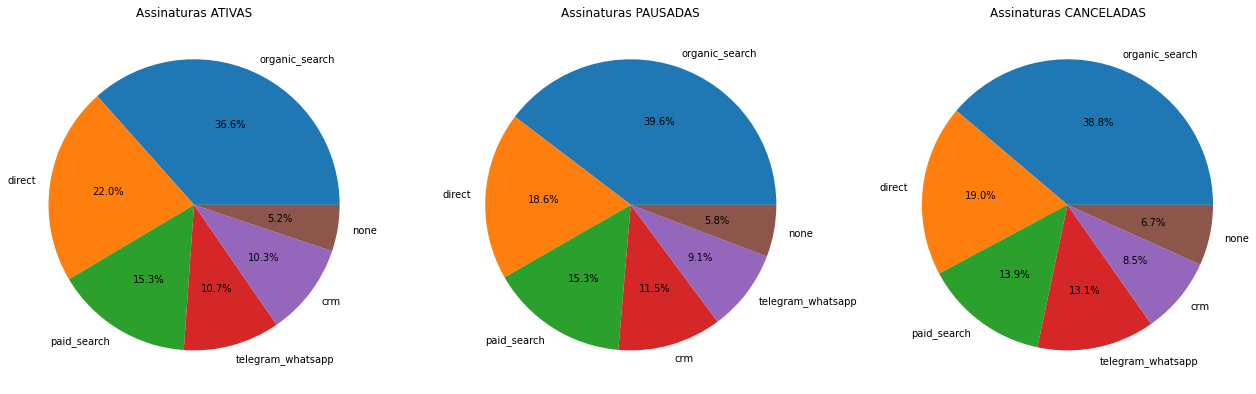

In [ ]:
fig = plt.figure(figsize=(30,15))

ax1 = plt.subplot2grid((2,4),(0,0))
plt.pie(dataset[dataset.status.eq('active')]['marketing_source'].value_counts(sort = True), labels=dataset[dataset.status.eq('active')]['marketing_source'].value_counts(sort=True).index, autopct='%1.1f%%')
plt.title('Assinaturas ATIVAS')

ax2 = plt.subplot2grid((2, 4), (0, 1))
plt.pie(dataset[dataset.status.eq('paused')]['marketing_source'].value_counts(sort = True), labels=dataset[dataset.status.eq('paused')]['marketing_source'].value_counts(sort=True).index,autopct='%1.1f%%')
plt.title('Assinaturas PAUSADAS')

ax3 = plt.subplot2grid((2, 4), (0, 2))
plt.pie(dataset[dataset.status.eq('canceled')]['marketing_source'].value_counts(sort = True), labels=dataset[dataset.status.eq('canceled')]['marketing_source'].value_counts(sort=True).index,autopct='%1.1f%%')
plt.title('Assinaturas CANCELADAS')

plt.show()

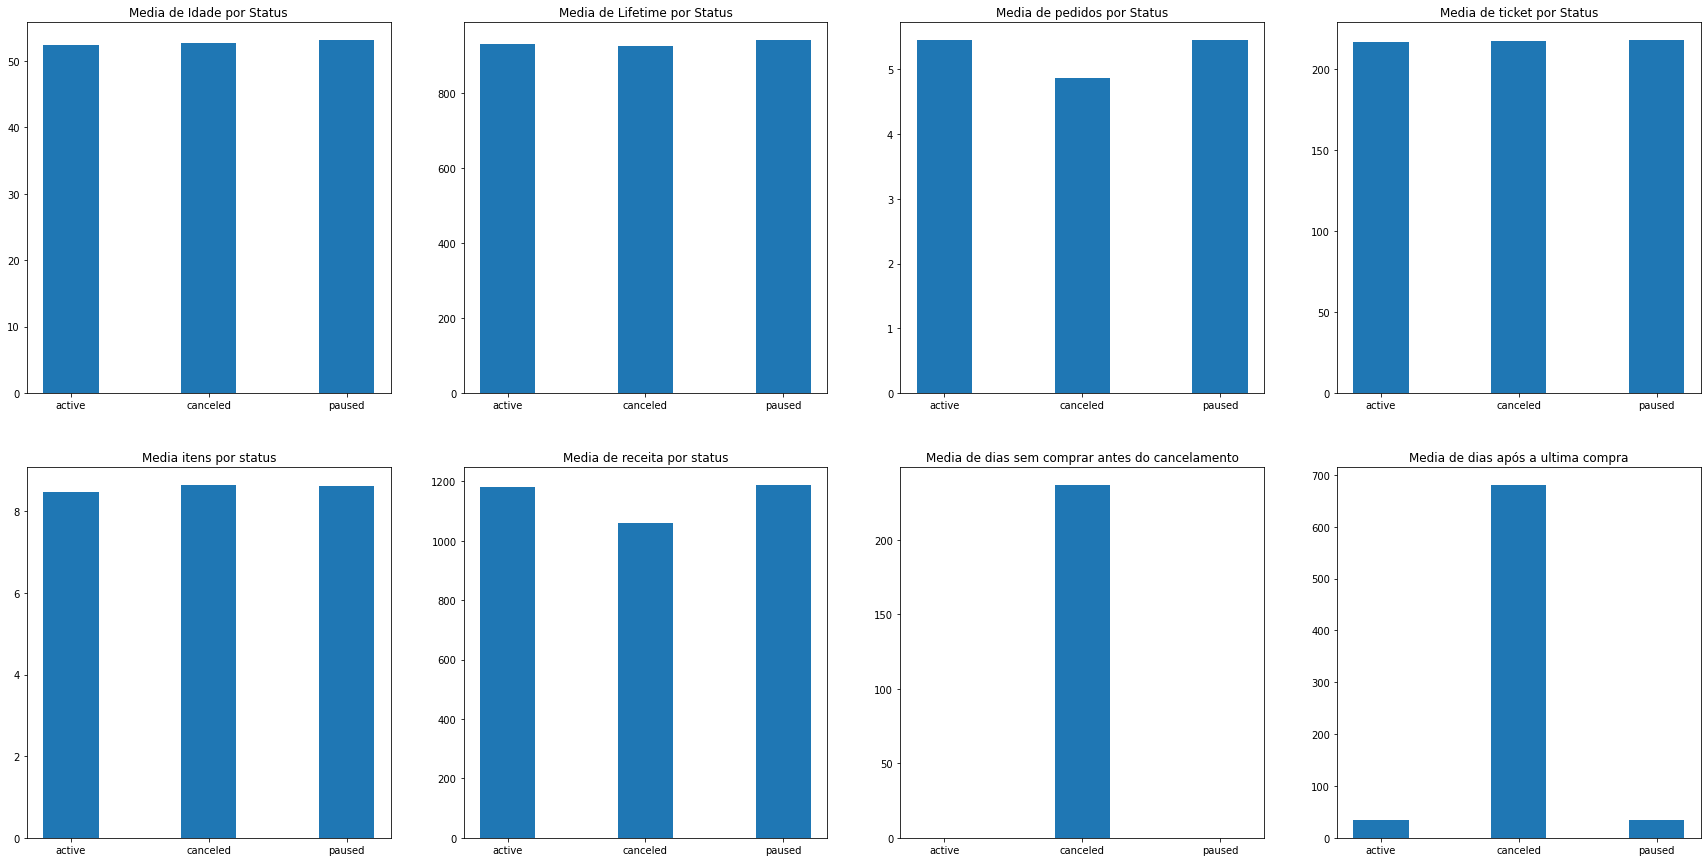

In [ ]:
fig = plt.figure(figsize=(30,15))

ax1 = plt.subplot2grid((2,4),(0,0))
plt.bar(dataset.groupby("status")["age"].mean().index,dataset.groupby("status")["age"].mean(), width = 0.4)
plt.title('Media de Idade por Status')

ax2 = plt.subplot2grid((2, 4), (0, 1))
plt.bar(dataset.groupby("status")["lifetime"].mean().index,dataset.groupby("status")["lifetime"].mean(), width = 0.4)
plt.title('Media de Lifetime por Status')

ax3 = plt.subplot2grid((2, 4), (0, 2))
plt.bar(dataset.groupby("status")["all_orders"].mean().index,dataset.groupby("status")["all_orders"].mean(), width = 0.4)
plt.title('Media de pedidos por Status')

ax4 = plt.subplot2grid((2, 4), (0, 3))
plt.bar(dataset.groupby("status")["average_ticket"].mean().index,dataset.groupby("status")["average_ticket"].mean(), width = 0.4)
plt.title('Media de ticket por Status')

ax5 = plt.subplot2grid((2, 4), (1, 0))
plt.bar(dataset.groupby("status")["items_quantity"].mean().index,dataset.groupby("status")["items_quantity"].mean(), width = 0.4)
plt.title('Media itens por status')

ax6 = plt.subplot2grid((2, 4), (1, 1))
plt.bar(dataset.groupby("status")["all_revenue"].mean().index,dataset.groupby("status")["all_revenue"].mean(), width = 0.4)
plt.title('Media de receita por status')

ax7 = plt.subplot2grid((2, 4), (1, 2))
plt.bar(dataset.groupby("status")["days_without_buying_before_canceling"].mean().index,dataset.groupby("status")["days_without_buying_before_canceling"].mean().fillna(0), width = 0.4)
plt.title('Media de dias sem comprar antes do cancelamento')

ax8 = plt.subplot2grid((2, 4), (1, 3))
plt.bar(dataset.groupby("status")["recency"].mean().index,dataset.groupby("status")["recency"].mean(), width = 0.4)
plt.title('Media de dias após a ultima compra')

plt.show()

In [ ]:
dataset.groupby("status")["days_without_buying_before_canceling"].mean()

status
active        0.000000
canceled    237.079208
paused        0.000000
Name: days_without_buying_before_canceling, dtype: float64

Os clientes ficam em média 237 dias sem realizar compras antes de realizar o cancelamento. 


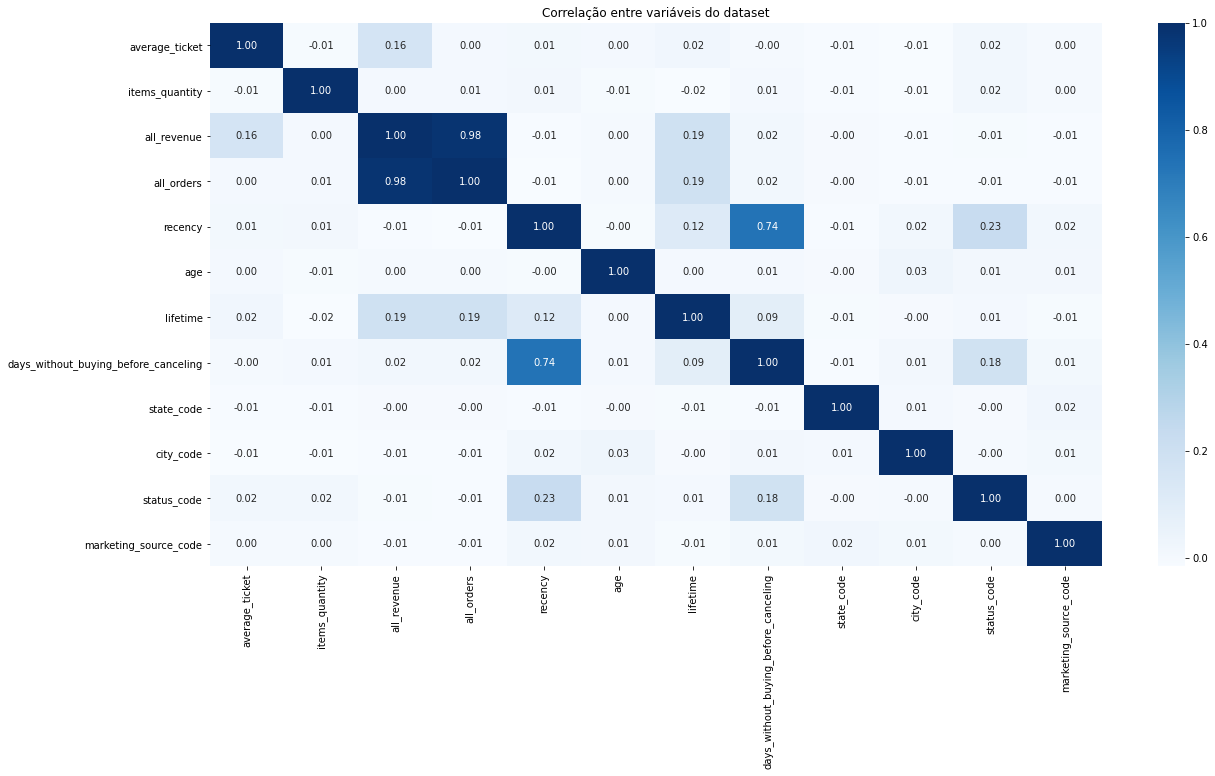

In [ ]:
plt.figure(figsize=(20, 10))
sns.heatmap(datasetencode.corr(),
            annot = True,
            fmt = '.2f',
            cmap='Blues')
plt.title('Correlação entre variáveis do dataset')
plt.show()

In [ ]:
X = datasetencode.drop(labels = ["created_at","updated_at","deleted_at","status","version","city","state","neighborhood","last_date_purchase","marketing_source","status_code"],axis = 1)
y = datasetencode.status_code# Criando conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)#Treinando modelo
model  = RandomForestClassifier()
model.fit(X_train, y_train)#importância de cada feature
model.feature_importances_

array([0.09907894, 0.05284072, 0.08213959, 0.03132028, 0.20027845,
       0.07196027, 0.090333  , 0.18831139, 0.06184891, 0.09009477,
       0.03179367])

Text(0.5, 1.0, 'Importância de cada feature')

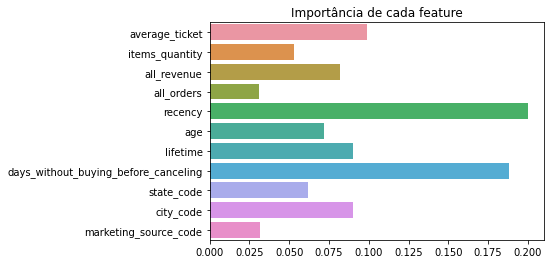

In [ ]:
importances = pd.Series(data=model.feature_importances_, index=X.columns)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada feature')

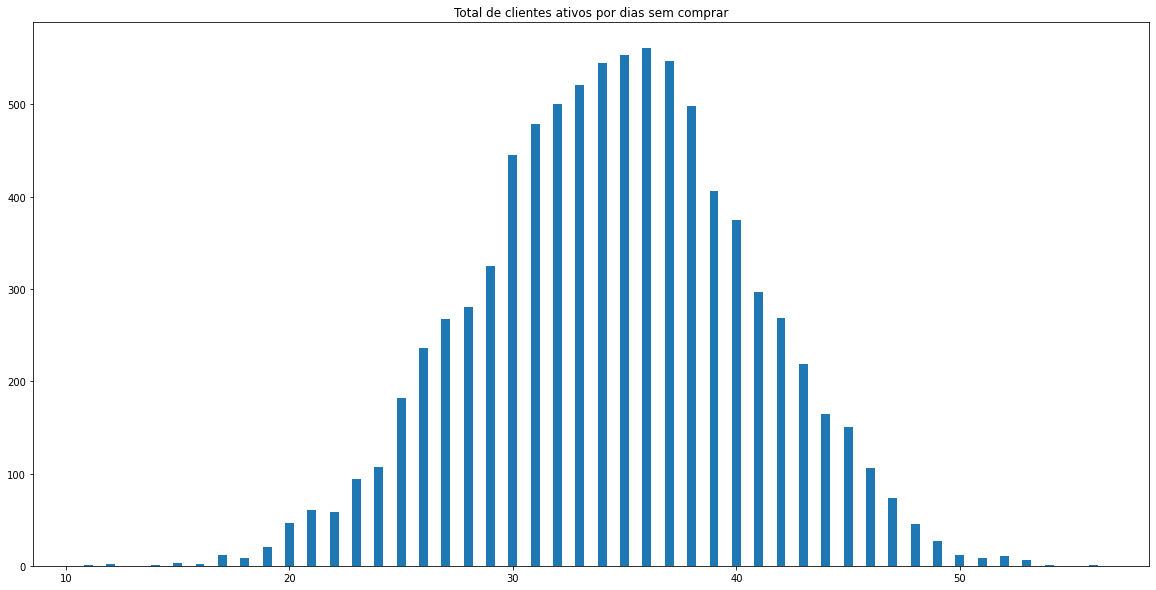

In [ ]:
fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot2grid((1,1),(0,0))
plt.bar(dataset[dataset.status.eq('active')].groupby(['recency'])['recency'].count().index,dataset[dataset.status.eq('active')].groupby(['recency'])['recency'].count(), width = 0.4)
plt.title('Total de clientes ativos por dias sem comprar')
plt.show()


In [ ]:
df = dataset[dataset.status.eq('active')].groupby(['recency'])['recency'].count()

In [ ]:
df[df.index.get_loc(35):].sum()


4329